In [1]:
%load_ext autoreload
%autoreload 2

In [687]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests

from decode_fish.funcs.merfish_eval import *
# from decode_fish.funcs.merfish_viz import *
from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [7]:
bench_df, code_ref, targets = get_benchmark()
istdeco_df = get_istdeco()

13832
156501


In [816]:
sweep_name = 'merfish_sweep_ae_2_'
# sweep_name = 'merfish_sweep_ci_15_'

df_dict = {}
df_dict['istdeco'] = istdeco_df
df_dict['bench'] = bench_df

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}*'):
    dec_df = pd.read_csv(f)
    df_dict['dec_'+f.split(sweep_name)[-1].split('.csv')[0]] = dec_df

In [817]:
bench_df = bench_df[bench_df['gene'] != 'MALAT1']
istdeco_df = istdeco_df[istdeco_df['gene'] != 'MALAT1']
for k in df_dict:
    df_dict[k] = df_dict[k][df_dict[k]['gene'] != 'MALAT1']

In [818]:
for k in df_dict:
    print(k, len(df_dict[k]))

istdeco 152428
bench 12555
dec_shuffle_ch:Truexenabled:Truexseed:0 31033
dec_shuffle_ch:Truexenabled:Truexseed:2 39342
dec_shuffle_ch:Falsexenabled:Truexseed:3 23222
dec_shuffle_ch:Falsexenabled:Truexseed:2 40339
dec_shuffle_ch:Falsexenabled:Truexseed:0 42127
dec_shuffle_ch:Truexenabled:Truexseed:1 43866
dec_shuffle_ch:Truexenabled:Truexseed:3 11378
dec_shuffle_ch:Falsexenabled:Truexseed:1 43928


KeyError: 'dec_base'

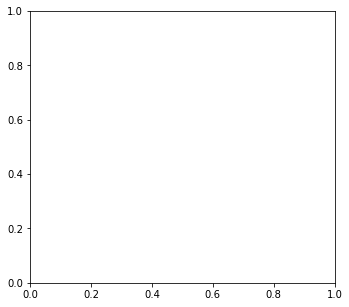

In [819]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(df_dict['dec_base']['x_sig'], histtype='step', bins=np.linspace(1,40,101))

plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    plt.hist(df_dict['dec_base'][f'int_{i}'], histtype='step', color=color, bins=np.linspace(0.5,10,101))

100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 233.65it/s]


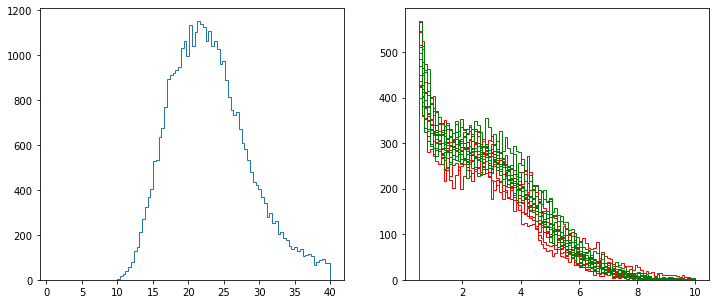

In [808]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(df_dict['dec_scaled']['x_sig'], histtype='step', bins=np.linspace(1,40,101))

plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    plt.hist(df_dict['dec_scaled'][f'int_{i}'], histtype='step', color=color, bins=np.linspace(0.5,10,101))

In [782]:
# res_sub = df_dict['dec_depth:3'].nsmallest(17500, 'code_err')
res_sub = df_dict['dec_enabled:True'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

In [783]:
matches, bench_match = match_bench(res_sub, bench_sub)

[49.452564189189125, 51.47048258835754, 0.0]
Recall: 0.167
Precision: 0.140
Jaccard: 8.258
RMSE_vol: 130.643
Eff_3d: -12.621
FN: 10453.0 FP: 12898.0
Num. matches: 2102.000
Shift: 16.70,20.92,0.00


In [593]:
matches, bench_match = match_bench(ist_sub, bench_sub)

[nan, nan, nan]
Recall: 0.000
Precision: 0.000
Jaccard: 0.000
RMSE_vol: 0.000
Eff_3d: 0.000
FN: 12555.0 FP: 15000.0
Num. matches: 0.000
Shift: nan,nan,nan


KeyError: 'pred_idx'

12555 15000


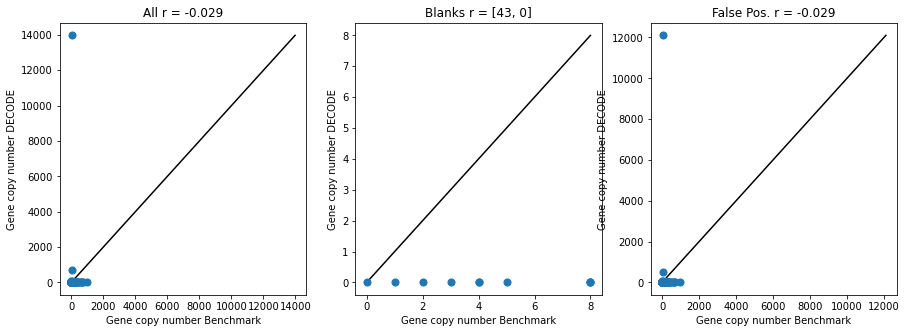

In [784]:
plot_gene_panels(res_sub, bench_sub, matches, targets)

In [753]:
test = pd.read_csv('../data/results/MERFISH/test.csv')

In [820]:
par_dict = {'ISTDECO':[df_dict['istdeco'], 'quality', False],
            'benchmark':[df_dict['bench'], 'total_magnitude', False]}

for i,k in enumerate(df_dict):
    if 'dec_' in k:
        par_dict[k] = [df_dict[k], 'code_err', True]
        
#         df_dict[k][f'net_qual_x'] = (0.9)*df_dict[k]['code_err'] + 0.1*(1-df_dict[k]['net_qual'])
    
for i,k in enumerate(df_dict):
    if 'dec_' in k:
        if 'net_qual' in df_dict[k]:
            df_dict[k][f'net_qual_x'] = (0.9)*df_dict[k]['code_err'] + 0.1*(1-df_dict[k]['net_qual'])
            par_dict[k+'_nq'] = [df_dict[k], 'net_qual_x', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=25000)
    roc_dict[k] = [x, y]

/tmp/ipykernel_41100/1091186416.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [821]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict['ISTDECO'][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [822]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,60], range_x=[0,20000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [771]:
# import seaborn as sns

# colmap = sns.color_palette("husl", 12)
# n_dec = len(df_dict) - 2
# cols = colmap[:2] + 2*colmap[2:2+n_dec]

# plt.figure(figsize=(10,8))

# for i,k in enumerate(roc_dict):
#     x, y = roc_dict[k]
#     ls = '--' if 'nq' in k else None
#     plt.plot(x, y, label=k, color=cols[i], linestyle=ls)
    
# plt.legend()
# plt.ylim(0, 100)
# plt.xlim(0, 24000)
# sns.despine()

/tmp/ipykernel_41100/3020605590.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_41100/3020605590.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



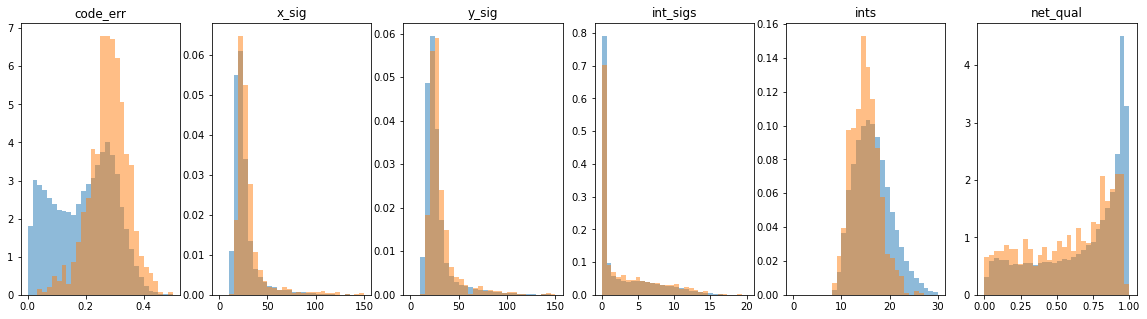

In [551]:
res_df = df_dict['dec_bs:3xenabled:True']
res_df['int_sigs'] = res_df[[f'int_sig_{i}' for i in range(16)]].values.sum(1)
res_df['ints'] = res_df[[f'int_{i}' for i in range(16)]].values.sum(1)
metrics = ['code_err', 'x_sig', 'y_sig', 'int_sigs','ints','net_qual']
bins = [np.linspace(0,0.5,31), np.linspace(0,150,31), np.linspace(0,150,31), np.linspace(0,20,31), np.linspace(0,30,31), np.linspace(0,1.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [571]:
from decode_fish.funcs.visualization import *
roc_dict = {}

res_df = df_dict['dec_bs:3xenabled:True']

for i in tqdm(range(6)):
#     res_df[f'k_{i}'] = (1-i*0.2)*res_df['code_err'] + i*0.2*res_df['comb_sig']/100
    res_df[f'k_{i}'] = (1-i*0.05)*res_df['code_err'] + i*0.05*(1-res_df['net_qual'])
    par_dict = {f'k_{i}':[res_df, f'k_{i}', True]}

    for k in par_dict:
        x, y = make_roc(*par_dict[k])
        roc_dict[k] = [x, y]
        
par_dict = {'bench_df':[bench_df, 'total_magnitude', False]}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]    

  0%|                                                                      | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_41100/2237120364.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


In [572]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict['k_0'][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [607]:
# fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,200])
# fig.show()

In [274]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

In [608]:
# ind = 0
# img = load_tiff_image(image_paths[ind])
# preds_px = nm_to_px(res_sub)[res_sub['gene']=='MALAT1']
# bench_px = nm_to_px(bench_match)[bench_match['gene']=='MALAT1']

# plt.figure(figsize=(25,25))
# plt.imshow(img[0,0])

# plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=1.)
# plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.0)

In [276]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [287]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

3


,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,...,int_14,int_sig_14,int_15,int_sig_15,net_qual,code_err,code_inds,gene,int_sigs,ints
46999,57971,0,1751.867,1873.1319,0.5,0.718189,0.114684,0.010159,25.40797,25.065601,...,0.062468,0.010853,0.000022,0.01,0.994344,0.04955,9,Blank-9,0.268984,11.825915


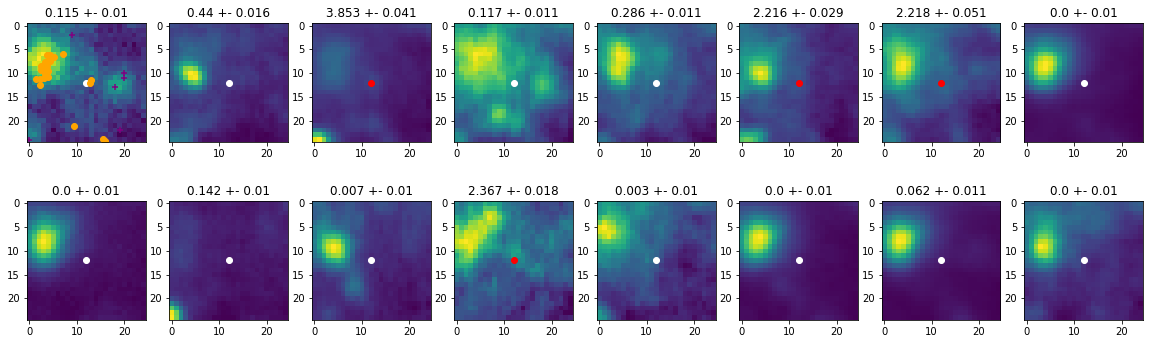

In [318]:
# Random predictions 
sub = res_sub
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 12, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([12],[12], color=color)
    
    plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [307]:
res_crop

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,...,int_14,int_sig_14,int_15,int_sig_15,net_qual,code_err,code_inds,gene,int_sigs,ints
13251,19407,0,6.97590,9.87360,0.5,0.983756,5.575228,0.011979,12.270225,12.829820,...,0.000477,0.010000,0.000005,0.010000,0.998690,0.012115,52,FASN,0.168864,22.653039
13344,19515,0,17.17060,16.35890,0.5,1.000000,0.013534,0.010000,12.683928,14.597790,...,0.008837,0.010000,0.001516,0.010000,0.999383,0.037953,33,ANKRD52,0.160033,12.482871
13187,19328,0,0.05445,4.62990,0.5,1.000000,0.008484,0.010002,15.766893,21.747803,...,0.011783,0.010001,3.851227,0.034273,0.996156,0.071866,102,USP9X,0.278023,14.275106
13298,19463,0,18.73480,13.23810,0.5,0.999594,0.001423,0.010000,17.342777,17.274437,...,0.001777,0.010000,0.006936,0.010000,0.998381,0.080615,87,ASCC3,0.160038,10.810130
13400,19580,0,11.33430,20.98010,0.5,0.998866,0.003747,0.010000,11.164920,10.229874,...,3.396698,0.010002,0.004291,0.010000,0.998264,0.084914,75,SPTBN1,0.160027,17.544534
13287,19449,0,12.00016,12.76375,0.5,0.900951,1.332352,0.010006,17.513964,14.637901,...,0.006223,0.010000,0.201266,0.010000,0.998385,0.087511,1,Blank-10,0.160125,8.925646
13276,19437,0,0.28560,12.10555,0.5,1.000000,5.131915,0.010093,11.900434,21.171421,...,0.000020,0.010000,0.000726,0.010000,0.991987,0.090509,52,FASN,0.160753,20.500066
13225,19374,0,15.92586,7.71930,0.5,0.987426,0.055468,0.010000,11.221094,12.368498,...,0.005409,0.010000,1.792633,0.010001,0.998154,0.094966,50,SRRM2,0.160051,15.825204
13131,19263,0,2.51910,1.24098,0.5,1.000000,3.308525,0.011649,18.340080,20.822334,...,0.790096,0.010584,0.069930,0.010004,0.996351,0.097030,52,FASN,0.165316,11.242976


KeyError: 'tar_idx'

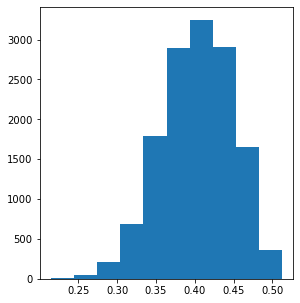

In [279]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False)
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101))
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)

In [36]:
fn_inds = fns['loc_idx'].values
# btps = bench_match.loc[bench_match['loc_idx'].isin(matches['tar_idx'])]
# fn_inds = btps['loc_idx'].values

,Unnamed: 0,barcode,barcode_id,fov_id,total_magnitude,area,is_exact,error_bit,error_dir,av_distance,x,y,wx,wy,gene,code,frame_idx,loc_idx,int,z
3034,12430,1010000000000110,49,0,66.170219,9,0,2,0,0.400019,1117.047144,1646.129023,1117.792847,1647.254639,RNF169,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]",0,3034,66.170219,0.5


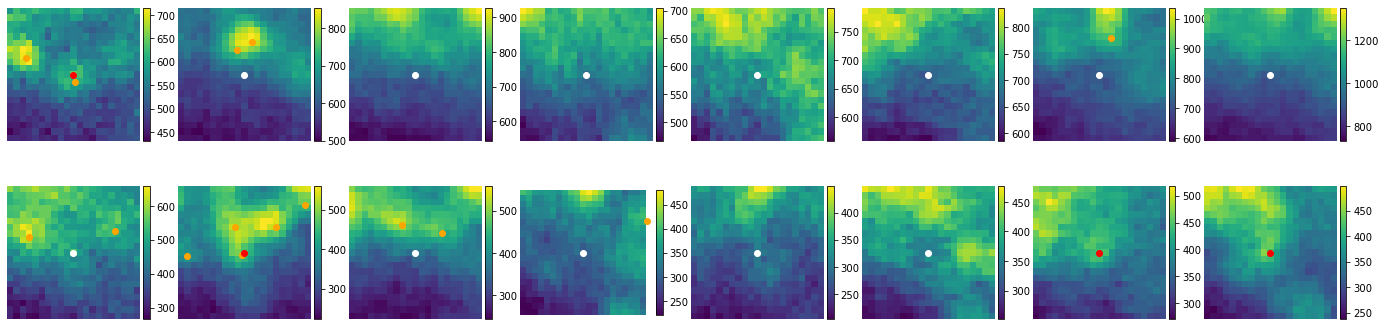

In [37]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]
# ind = 1607

b_loc = nm_to_px(bench_match[bench_match['loc_idx'] == ind]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [44]:
blank_df = res_sub[res_sub['gene'].str.contains('Blank')]
blank_df = blank_df.sort_values('logdist', ascending=False)

In [61]:
blank_df.groupby('cc')['cc'].count().values / res_sub.groupby('cc')['cc'].count().values*100

array([2.34814671, 0.35903062, 2.15889465])

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig,group_idx,code,cc,rmses,logdist,gene
31040,36361,0,209.70791,552.50746,0.5,0.861657,6.397343,0.619625,29.323174,20.414253,100.0,1.061913,9485,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,6.431063,-9.050423,Blank-9


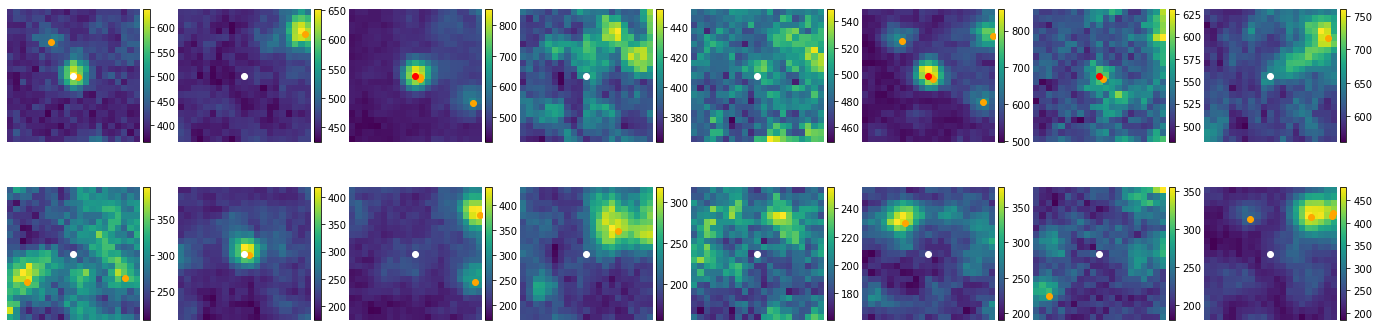

In [51]:
b_loc = nm_to_px(blank_df).iloc[2]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [35]:
b_m = bench_match[bench_match['loc_idx'] == m['tar_idx']]
p_m = res_df_filt[res_df_filt['loc_idx'] == m['pred_idx']]

NameError: name 'm' is not defined

In [ ]:
display(p_m)
display(b_m)

In [809]:
for c in range(2):
    for i in range(8):

        img = load_tiff_image(image_paths[i])
        preds_px = nm_to_px(pred_df[pred_df['frame_idx']==(i+c*8)])
        plt.figure(figsize=(25,25))
        plt.imshow(img[c,0])
        plt.title('i'+str(i)+'c'+str(c))

        plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.5)
        plt.show()

NameError: name 'pred_df' is not defined

In [ ]:
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

In [ ]:
# How many blank-genes (false positives) do we accept?
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

# Download benchmark
bench_raw = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv',\
                    dtype={'barcode': object})

# Filter benchmark

ns = []

for i in range(1,101):
    bench = bench_raw[bench_raw['area'] > 3]
    thresh = bench[bench['gene'].isin(non_targeted_names)]['total_magnitude'].nlargest(i).iloc[-1]
    bench = bench[bench['total_magnitude'] > thresh]
    ns.append(len(bench))

In [282]:
zoe_ps = np.array([81,88,85,79,65,69,67,70,63,80,80,74,69,85,71,80,70,81,80,79,89,84,87,79,80,90,80,78,81,83,76,100,85,95,87,91,76,73,95,88,79,67,90,89,82,87,88,76,81,87,85,78,83,84,84,76,75,88,81,79,87,91,83,91,75,86])
print(np.mean(zoe_ps))

81.28787878787878


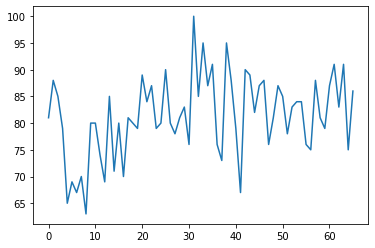

In [302]:
plt.plot(zoe_ps)

(array([ 2.,  6.,  3.,  6., 18., 11., 10.,  7.,  2.,  1.]),
 array([ 63. ,  66.7,  70.4,  74.1,  77.8,  81.5,  85.2,  88.9,  92.6,
         96.3, 100. ]),
 <BarContainer object of 10 artists>)

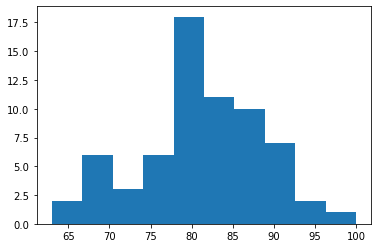

In [303]:
plt.hist(zoe_ps)